# ITU-ML5G-PS-005-KDDI Task2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/gakusai/master/ITU-ML5G-PS-005-KDDI-UT-NakaoLab-AI

/content/drive/MyDrive/gakusai/master/ITU-ML5G-PS-005-KDDI-UT-NakaoLab-AI


In [3]:
import gc
import numpy as np
import pandas as pd
from tools.preprocessing import Processor
from tools.generator import ReccurentTrainingGenerator, ReccurentTestGenerator

# Load data

In [4]:
train_0 = pd.read_csv('data/ML5G-PS-005_train_0.csv', index_col=0, header=0)
train_1 = pd.read_csv('data/ML5G-PS-005_train_1.csv', index_col=0, header=0)
train_2 = pd.read_csv('data/ML5G-PS-005_train_2.csv', index_col=0, header=0)
train_3 = pd.read_csv('data/ML5G-PS-005_train_3.csv', index_col=0, header=0)
train_4 = pd.read_csv('data/ML5G-PS-005_train_4.csv', index_col=0, header=0)
train_5 = pd.read_csv('data/ML5G-PS-005_train_5.csv', index_col=0, header=0)
train_data = pd.concat([train_0, train_1, train_2, train_3, train_4, train_5])
del train_0, train_1, train_2, train_3, train_4, train_5

test_0 = pd.read_csv('data/ML5G-PS-005_test_0.csv', index_col=0, header=0)
test_1 = pd.read_csv('data/ML5G-PS-005_test_1.csv', index_col=0, header=0)
test_2 = pd.read_csv('data/ML5G-PS-005_test_2.csv', index_col=0, header=0)
test_data = pd.concat([test_0, test_1, test_2])
del test_0, test_1, test_2
gc.collect()

0

In [5]:
preprocessor = Processor(train_data, test_data)

In [6]:
X, Y, test_X, test_Y = preprocessor.get_diff_data()
test_labels = preprocessor.test_label.values

In [7]:
del train_data, test_data
gc.collect()

117

# Train

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
timesteps = 15
delay = 45
batch_size = 64
input_dim = X.shape[-1]

In [ ]:
input = Input(shape=(timesteps, input_dim))
lstm = LSTM(256, input_shape=(timesteps, input_dim), return_sequences=True)(input)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.5)(lstm)
dense = Dense(1)(dropout)
model = Model(inputs=input, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 329)]         0         
                                                                 
 lstm (LSTM)                 (None, 15, 256)           600064    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,125,633
Trainable params: 1,125,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_X = X[:500*70]
train_Y = Y[:500*70]
val_X = X[500*70:]
val_Y = Y[500*70:]

In [ ]:
train_generator = ReccurentTrainingGenerator(train_X, train_Y, batch_size, timesteps, delay)
val_generator = ReccurentTrainingGenerator(val_X, val_Y, batch_size, timesteps, delay)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x=train_generator, epochs=20, verbose=1, callbacks=callback, validation_data=val_generator)

Epoch 1/20
79/79 [==============================] - 6s 21ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 2/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 4/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 5/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/20
79/79 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0022


In [22]:
model.save('models/diff/LSTM_diff_ITU_'+str(delay))

# Evaluation

In [9]:
from tools.metrics import Evaluation

In [13]:
test_generator = ReccurentTestGenerator(test_X, batch_size, timesteps, delay)

In [16]:
model = keras.models.load_model('models/diff/LSTM_diff_ITU_'+str(delay))

In [17]:
pred = model.predict(test_generator)
pred = pred.reshape(300, -1)

47/47 [==============================] - 5s 5ms/step


In [18]:
test_Y = test_Y.values.reshape(300, -1)

In [19]:
evaluation = Evaluation(pred, test_Y, test_labels, timesteps, delay, threshold=0.3)

In [20]:
evaluation.MSE()

0.002324476631794711

In [21]:
evaluation.score()

[[225   0]
 [  3  72]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       225
           1       1.00      0.96      0.98        75

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



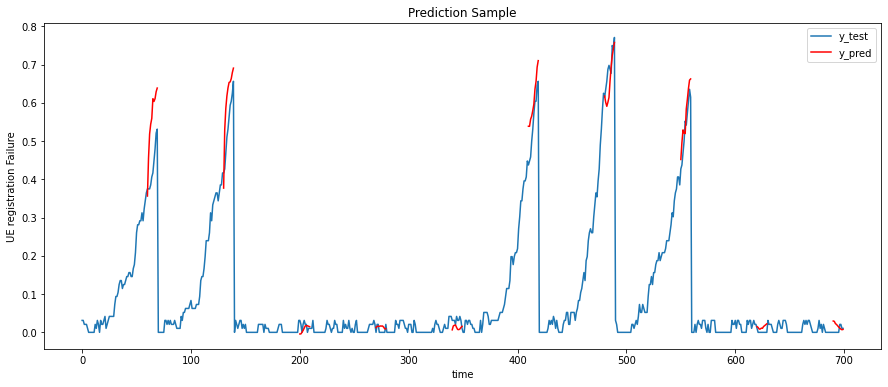

In [ ]:
evaluation.visualization()